# Neural network training and testing 

This notebook trains and tests a neural network to predct wavefield borders.

In [ ]:
!pip install torchsummaryX --quiet
!pip install wandb --upgrade --quiet

     |████████████████████████████████| 1.8MB 13.7MB/s 
     |████████████████████████████████| 102kB 13.3MB/s 
     |████████████████████████████████| 133kB 60.2MB/s 
     |████████████████████████████████| 174kB 68.3MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 


In [ ]:
!nvidia-smi

Sat Jun 12 13:42:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/My\ Drive/ML_Ultrasound_Project/UROPdata

/content/drive/My Drive/ML_Ultrasound_Project/UROPdata


In [ ]:
# WandB is used for tracking training and hyperparameter tuning
import wandb
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Create classes and functions, load perceptual loss network

In [ ]:
# Import libraries
from networks.convlstm import RNN
from networks.loss_net import LossNetwork

import numpy as np
import math
import numbers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.lines
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import torch
from torch import Tensor
from torch import nn
import torch.nn.functional as F
from torch.nn.modules.utils import _pair
from torch import optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import Parameter
from torchvision.models import vgg
import torchvision.transforms as transforms
from torchvision.transforms.functional import hflip
from torchvision.transforms.functional import vflip
from torchvision.transforms.functional import rotate

from sklearn import preprocessing
from sklearn.model_selection import KFold
from scipy.ndimage import gaussian_filter
from torchsummaryX import summary
from tqdm.notebook import tqdm
from collections import namedtuple
from PIL import ImageFilter

import time
import random
import os
import collections

torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
# Data must be stored on GPU to use GPU for training
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
# Generator
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))


In [ ]:
def loss_batch(model, loss_network, loss_func, xb, yb, opt=None):

    # plt.figure()
    # plt.imshow(np.rot90(np.fliplr(yb[:,:,0].to('cpu').detach().numpy())))
    # plt.show()

    predictions = (model(xb)+1)/2
    targets = (yb.squeeze(2)+1)/2

    pred_labels, labels = reshape_for_loss_net(predictions, targets)

    features_pred_labels = loss_network(pred_labels)
    features_labels = loss_network(labels)

    with torch.no_grad():
        f_labels = features_labels[1].detach()

    loss = loss_func(features_pred_labels[1], f_labels)

    if opt != None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [ ]:
def reshape_for_loss_net(pred_yb, yb):

    pred_yb = pred_yb.repeat(1,3,1,1)
    pred_yb = pred_yb.repeat_interleave(10, dim=2)
    pred_yb = pred_yb.repeat_interleave(23, dim=3)
    yb = yb.repeat(1,3,1,1)
    yb = yb.repeat_interleave(10, dim=2)
    yb = yb.repeat_interleave(23, dim=3)

    # print('Label ', yb.shape)
    # plt.figure()
    # plt.imshow(np.rot90(yb[0,0,].to('cpu').detach().numpy()))
    # plt.show()

    # print('Predicted label')
    # plt.figure()
    # plt.imshow(np.rot90(pred_yb[0,0,].to('cpu').detach().numpy()))
    # plt.show()
    
    return pred_yb, yb


In [ ]:
# Fit model
def fit(epochs, model, loss_network, loss_func, opt, train_dl, valid_dl, batches, verbose, wandb):
    train_losses = []
    validation_losses = []

    example_ct = 0
    batches_tot = 0
    
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))

        logs = {}
      
        batch = 1
        
        model.train()

        loss = 0

        # With progress bar
        if verbose == 1:
            for xb, yb in tqdm(train_dl):
                batch_loss, batch_size = loss_batch(model, loss_network, loss_func, xb, yb, opt)
                loss += batch_loss              
                print('{}/{}'.format(batch, batches), end="\r")
                batch+=1

        # Without progress bar
        if verbose == 2:
            for xb, yb in train_dl:
                batch_loss, batch_size = loss_batch(model, loss_network, loss_func, xb, yb, opt)
                loss += batch_loss                
                print('{}/{}'.format(batch, batches), end="\r")
                batch+=1     

        loss=loss/len(train_dl)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_network, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        wandb.log({"epoch": epoch+1, "loss": loss, "val_loss": val_loss})

        train_losses.append(loss)
        validation_losses.append(val_loss)

        print('loss = {}      val_loss: {}'.format(loss, val_loss))

        if (epoch+1)%25 == 0 and epoch > 0:
          torch.save(model.state_dict(), '/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/rnn48_state_dict_zeroed_{}'.format(epoch+1))
          torch.save(opt.state_dict(), '/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/rnn48_opt_state_dict_zeroed_{}'.format(epoch+1))
          print('Saved state dict')
          
        # Plot training curve for loss
        plt.plot(train_losses[:])
        plt.plot(validation_losses[:])
        plt.title('loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.yscale('log')
        plt.legend(['train', 'validation'], loc = 'upper right')
        plt.show()

    return train_losses, validation_losses

In [ ]:
def k_fold_train(x_train, y_train, loss_network, bs, batches, verbose):
    
    # Hyperparameters - to be tuned
    wandb.init(project="ML_US", config={
    "learning_rate": 0.001,
    "NUMconvLSTMlayers": 3,
    "NUMconvLSTMfeatures": 8,
    "OutputConvLayers": 0,
    })
    config = wandb.config

    # To implement k-fold validation...
    # kfold = KFold(n_splits=20)

    # k_train_losses = []
    # k_val_losses = []

    # for fold, (train_index, valid_index) in enumerate(kfold.split(x_train, y_train)):

    fold = 0
        
    ### Dividing data into folds
    x_train_fold = x_train[8700:]
    x_valid_fold = x_train[:8700]
    y_train_fold = y_train[8700:]
    y_valid_fold = y_train[:8700]

    train_ds = TensorDataset(x_train_fold, y_train_fold)
    valid_ds = TensorDataset(x_valid_fold, y_valid_fold)

    train_dl, valid_dl = get_data(train_ds, valid_ds, bs)

    train_dl = WrappedDataLoader(train_dl, preprocess)
    valid_dl = WrappedDataLoader(valid_dl, preprocess)

    # CNN model
    model = RNN(config.NUMconvLSTMlayers, config.NUMconvLSTMfeatures)
    # Store model on GPU for training
    model.to(dev)
    wandb.watch(model)
    # model.load_state_dict(torch.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/rnn37_state_dict_zeroed_25'))

    # Hyperparameters
    loss_func = nrmse_loss
    learning_rate = config.learning_rate
    EPOCHS = 1000
    opt = optim.Adam(model.parameters(), lr=learning_rate)
    # opt.load_state_dict(torch.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/rnn37_opt_state_dict_zeroed_25'))

    print('K-fold: {}/5'.format(fold+1))

    train_losses, val_losses = fit(EPOCHS, model, loss_network, loss_func, opt, train_dl, valid_dl, batches, verbose, wandb)

    k_train_losses.append(train_losses)
    k_val_losses.append(val_losses)
    
    return k_train_losses, k_val_losses


In [ ]:
def preprocess(x, y):
    return x.view(-1, 9, 1, 23, 23).to(dev), y.to(dev)

In [ ]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs),
        DataLoader(valid_ds, batch_size=bs),
    )

In [ ]:
# NRMSE loss function
def nrmse_loss(y_pred, y_true):
    diff = torch.div(y_pred - y_true, torch.max(y_true) - torch.min(y_true) + 1e-6)
    return torch.sqrt(torch.mean(torch.square(diff)))

In [ ]:
def custom_loss(y_pred, y_true):
    w = 0.5
    false_zero = 0 #-0.08734477

    error = nrmse_loss(y_pred, y_true)
    error = torch.where((y_true<false_zero*-1.1 and y_true>false_zero*-0.9), error, error*w)

    return torch.mean(error)

In [ ]:
vgg_model = vgg.vgg16(pretrained=True)
# # Replace MaxPool layers with AvgPool
# for layer in [4, 9, 16, 23, 30]:
#   vgg_model.features[layer] = nn.AvgPool2d(vgg_model.features[layer].kernel_size)
vgg_model.to(dev)
loss_network = LossNetwork(vgg_model)
loss_network.eval()

# summary(loss_network, torch.zeros(64,3,60,66).to(dev))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, 

## Load training data and train RNN

(138000, 2)
Training labels


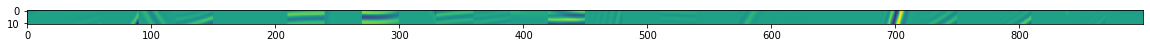

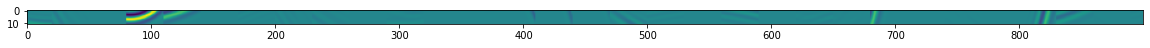

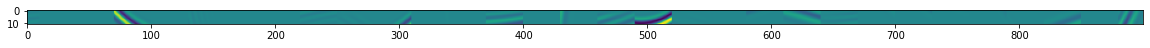

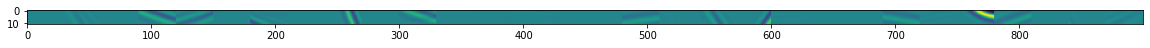

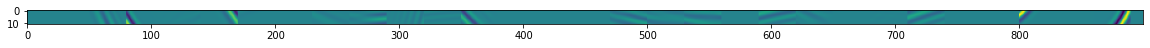

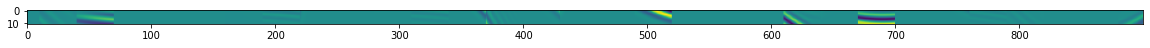

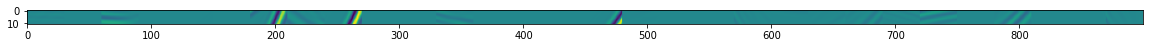

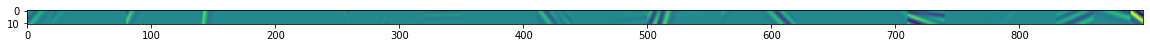

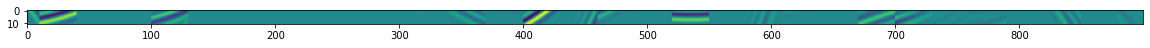

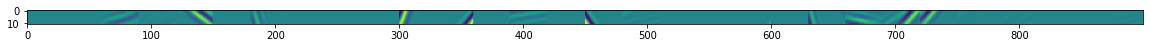

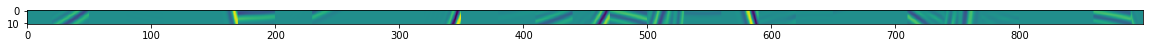

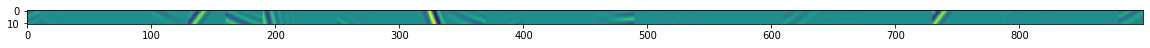

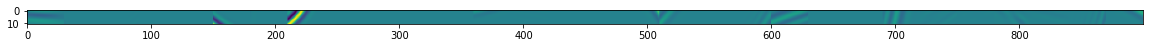

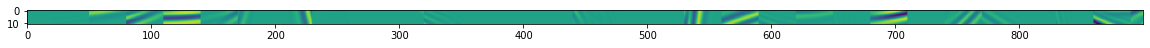

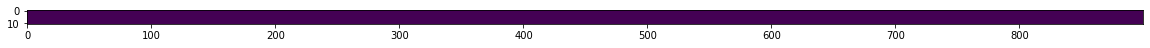

torch.Size([144000, 1, 9, 23, 23]) torch.Size([144000, 11, 1])


In [ ]:
# Load dataset created from notebook 'PreprocessData'
t_data = np.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/artificial_training_data.npz', allow_pickle=True)

training_data = t_data['arr_0'] # saves the array from t_data file
print(training_data.shape)

# Split into network inputs and outputs
train_X = []
train_Y = []

for i in range (len(training_data)):
  train_X.append(training_data[i][0])
  train_Y.append(training_data[i][1])
    
for i in range(6000):
  train_X.append(np.zeros((9,23,23)))
  train_Y.append(np.zeros((11,1)))

x_train, y_train = map(
    torch.cuda.FloatTensor, (train_X[:], train_Y[:])
)

# Plot example targets
print('Training labels')
train_Y = np.array(train_Y)
for i in range(0, len(train_Y), 10000):
  plt.figure(figsize=(20,20))
  plt.imshow(np.rot90(train_Y[i:i+900,].squeeze()))
  plt.show()

# Add axis to training and validation arrays
x_train = x_train.unsqueeze(1)

# Check correct shape
print(x_train.shape, y_train.shape)



In [ ]:
# Train model with k-fold validation
batch_size = 30
batches = math.ceil(len(train_X)/batch_size)
verbose = 2       # 1: progress bar, 2: without progress bar

k_train_losses, k_val_losses = k_fold_train(x_train, y_train, loss_network, batch_size, batches, verbose)

## Load testing data

In [ ]:
# Load test dataset
testing_data = np.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/artificial_test_data.npz', allow_pickle=True)
test_data = testing_data['arr_0'] 

# Reorganises the array into input and label arrays, same as for training
test_X = []
test_Y = []

for i in range (len(test_data)):
  test_X.append(test_data[i][0])
  test_Y.append(test_data[i][1])

x_test, y_test = map(
    torch.cuda.FloatTensor, (test_X[:], test_Y[:])
)

test_Y = np.array(test_Y)

# Add axis to training and validation arrays
x_test = x_test.unsqueeze(1)

# Check correct shape
print(x_test.shape, y_test.shape)


torch.Size([42000, 1, 9, 23, 23]) torch.Size([42000, 11, 1])


In [ ]:
test_ds = TensorDataset(x_test, y_test)

test_dl = DataLoader(test_ds, batch_size=30)

test_dl = WrappedDataLoader(test_dl, preprocess)

In [ ]:
# Load whole borders
border_images = np.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/whole_border_images.npz', allow_pickle=True)['a']
border_labels = np.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/whole_border_labels.npz', allow_pickle=True)['a']

norm = 3.005867554861652e-08

border_images /= norm
border_labels /= norm

print(border_images.shape, border_labels.shape)

x_borders, y_borders = map(
    torch.cuda.FloatTensor, (border_images, border_labels)
)

# Add axis to training and validation arrays
x_borders = x_borders.unsqueeze(1)

# Check correct shape
print(x_borders.shape, y_borders.shape)


(13500, 9, 23, 23) (13500, 11, 1)
torch.Size([13500, 1, 9, 23, 23]) torch.Size([13500, 11, 1])


In [ ]:
borders_ds = TensorDataset(x_borders, y_borders)
borders_dl = DataLoader(borders_ds, batch_size=300)
borders_dl = WrappedDataLoader(borders_dl, preprocess)

## Load trained RNN model and test

In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Load saved CNN weights
rnn = RNN(3,32)
rnn.to(dev)
rnn.load_state_dict(torch.load('/content/drive/My Drive/ML_Ultrasound_Project/UROPdata/rnn46_state_dict_zeroed_225'))
rnn.eval()

RNN(
  (convlstm1): CLSTM_cell(
    (conv): Sequential(
      (0): Conv2d(33, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(4, 128, eps=1e-05, affine=True)
    )
  )
  (convlstm2): CLSTM_cell(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(4, 128, eps=1e-05, affine=True)
    )
  )
  (convlstm3): CLSTM_cell(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GroupNorm(4, 128, eps=1e-05, affine=True)
    )
  )
  (reshape_output): ProcessOut(
    (tanh): Tanh()
    (flat): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=152352, out_features=11, bias=True)
  )
  (lambda_1): Lambda()
)

**Test on test dataset**

Generate predictions using the testing dataset
Test Perceptual Loss: 0.00020298994256547434
Test NRMSE Loss: 3.508969783782959
----------------------------------------------
Worst perceptual loss:  0.0029044358525425196


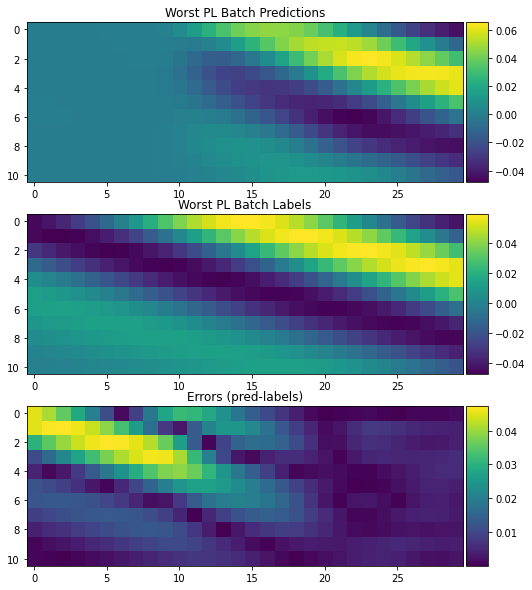

----------------------------------------------
Worst NRMSE loss:  301.171630859375


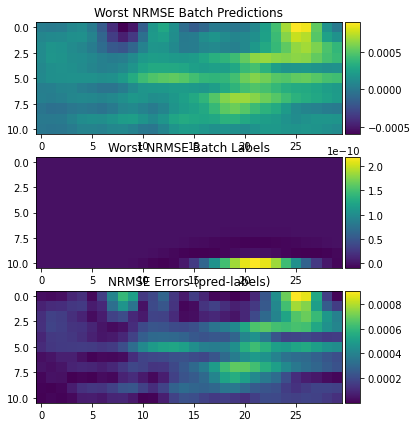

In [ ]:
print("Generate predictions using the testing dataset")

predictions = []
batch_loss = 0
batch_nrmse_loss = 0
batches = 0
loss_func = nrmse_loss

max_error = 0
max_nrmse_error = 0

rnn.eval()
for xb, yb in test_dl:
  with torch.no_grad():
      xb = Variable(xb.data, requires_grad=True)

      batch_predictions = rnn(xb)

      predictions.append(batch_predictions.cpu().detach().numpy())

      pred_labels, labels = reshape_for_loss_net((batch_predictions+1)/2, (yb.squeeze(2)+1)/2)

      features_pred_labels = loss_network(pred_labels)
      features_labels = loss_network(labels)

      with torch.no_grad():
          f_labels = features_labels[1].detach()


      perceptual_loss = loss_func(features_pred_labels[1], f_labels).item()
      nrmse = loss_func(batch_predictions, yb.squeeze(2))

      batch_loss += perceptual_loss
      batch_nrmse_loss += nrmse
      batches += 1

      if perceptual_loss > max_error:
        max_error = perceptual_loss
        worst_pred = batch_predictions.cpu().detach().numpy()
        worst_labels = yb.squeeze(2).cpu().detach().numpy()

      if nrmse > max_nrmse_error:
        max_nrmse_error = nrmse
        worst_nrmse_pred = batch_predictions.cpu().detach().numpy()
        worst_nrmse_labels = yb.squeeze(2).cpu().detach().numpy()
        

test_loss = batch_loss / batches
test_nrmse_loss = batch_nrmse_loss / batches

print('Test Perceptual Loss: {}'.format(test_loss))
print('Test NRMSE Loss: {}'.format(test_nrmse_loss))

predictions = np.reshape(predictions, (-1,11))

print('----------------------------------------------')
print('Worst perceptual loss: ', max_error)
fig, ax = plt.subplots(3,1, figsize=(10,10))

divider = make_axes_locatable(ax[0])
cax0 = divider.append_axes("right", size="5%", pad=0.05)
ax[0].set_title('Worst PL Batch Predictions')
im0 = ax[0].imshow(np.rot90(worst_pred, 3))
fig.colorbar(im0, cax=cax0)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes("right", size="5%", pad=0.05)
ax[1].set_title('Worst PL Batch Labels')
im1 = ax[1].imshow(np.rot90(worst_labels, 3))
fig.colorbar(im1, cax=cax1)

divider = make_axes_locatable(ax[2])
cax2 = divider.append_axes("right", size="5%", pad=0.05)
ax[2].set_title('Errors (pred-labels)')
im2 = ax[2].imshow(np.rot90(abs(worst_pred-worst_labels), 3))
fig.colorbar(im2, cax=cax2)
plt.show()

print('----------------------------------------------')
print('Worst NRMSE loss: ', max_nrmse_error.item())
fig, ax = plt.subplots(3,1, figsize=(10,7))

divider = make_axes_locatable(ax[0])
cax0 = divider.append_axes("right", size="5%", pad=0.05)
ax[0].set_title('Worst NRMSE Batch Predictions')
im0 = ax[0].imshow(np.rot90(worst_nrmse_pred, 3))
fig.colorbar(im0, cax=cax0)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes("right", size="5%", pad=0.05)
ax[1].set_title('Worst NRMSE Batch Labels')
im1 = ax[1].imshow(np.rot90(worst_nrmse_labels, 3))
fig.colorbar(im1, cax=cax1)

divider = make_axes_locatable(ax[2])
cax2 = divider.append_axes("right", size="5%", pad=0.05)
ax[2].set_title('NRMSE Errors (pred-labels)')
im2 = ax[2].imshow(np.rot90(abs(worst_nrmse_pred-worst_nrmse_labels), 3))
fig.colorbar(im2, cax=cax2)
plt.show()


In [ ]:
import matplotlib.ticker as ticker

In [ ]:
def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

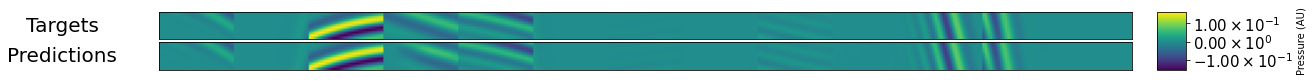

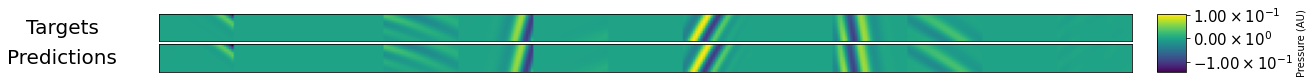

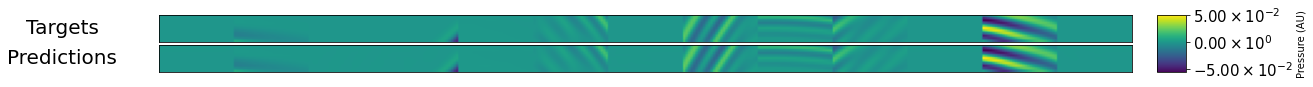

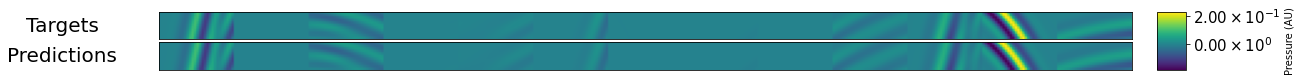

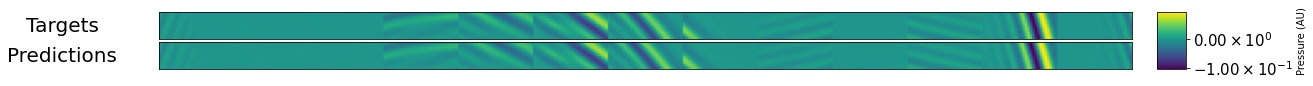

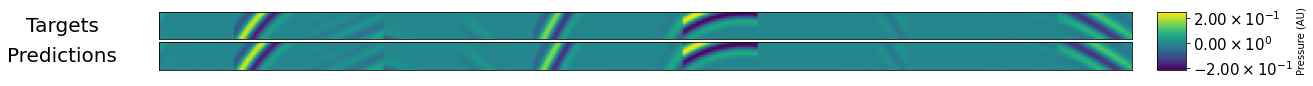

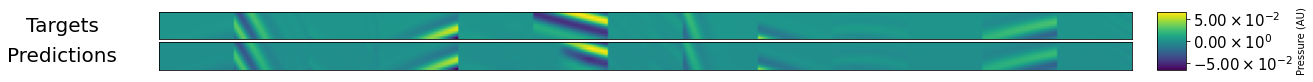

In [ ]:
test_Y = test_Y.squeeze()

border_labels = border_labels.squeeze()

for i in range(0,len(test_Y),6000):

  fig, ax = plt.subplots(2, 1, figsize=(20,1))

  y = ax[0].set_ylabel("Targets", fontsize=20, rotation=0, va="center")
  ax[0].yaxis.set_label_coords(-0.1,0.5)
  b = test_Y[i:i+390, ]
  b = np.rot90(b, 3)
  ax[0].imshow(b)
  ax[0].set_yticks([])
  ax[0].set_xticks([])

  y = ax[1].set_ylabel("Predictions", fontsize=20, rotation=0, va="center")
  ax[1].yaxis.set_label_coords(-0.1,0.5)
  a = predictions[i:i+390, ]
  a = np.rot90(a, 3)
  img = ax[1].imshow(a)
  ax[1].set_yticks([])
  ax[1].set_xticks([])

  fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.85,
                    wspace=0, hspace=0.1)
  
  img.set_clim([np.max(predictions[i:i+390, ]), np.min(predictions[i:i+390, ])])

  cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
  cbar = fig.colorbar(img, cax=cb_ax, format=ticker.FuncFormatter(fmt))
  cbar.ax.set_ylabel('Pressure (AU)', fontsize=10)
  cbar.ax.tick_params(labelsize=15)

  plt.show()

tensor([ 3.1035e-05,  4.1597e-05,  4.2022e-05,  7.8179e-06,  1.9636e-06,
         1.1939e-05,  4.1506e-07,  4.8380e-06, -9.7857e-06, -2.0675e-05,
        -1.3414e-05], device='cuda:0', grad_fn=<SelectBackward>)


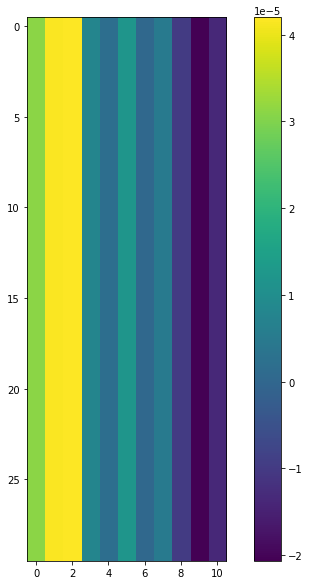

In [ ]:
# Check performance at predicting blank (zeros) borders
zeros = torch.cuda.FloatTensor(np.zeros((30,9,1,23,23)))
predZeros = rnn(zeros)
print(predZeros[0])
plt.figure(figsize=(10,10))
plt.imshow(predZeros.cpu().detach().numpy())
plt.colorbar()
plt.show()

**Test on whole borders**

In [ ]:
print("Generate predictions using the testing dataset")

border_predictions = []
batch_loss = 0
batch_nrmse_loss = 0
batches = 0
loss_func = nrmse_loss

max_error = 0
max_nrmse_error = 0

rnn.eval()
for xb, yb in borders_dl:
  with torch.no_grad():
      xb = Variable(xb.data, requires_grad=True)

      batch_predictions = rnn(xb)

      border_predictions.append(batch_predictions.cpu().detach().numpy())

      pred_labels, labels = reshape_for_loss_net((batch_predictions+1)/2, (yb.squeeze(2)+1)/2)

      features_pred_labels = loss_network(pred_labels)
      features_labels = loss_network(labels)

      with torch.no_grad():
          f_labels = features_labels[1].detach()


      perceptual_loss = loss_func(features_pred_labels[1], f_labels).item()
      nrmse = loss_func(batch_predictions, yb.squeeze(2))

      batch_loss += perceptual_loss
      batch_nrmse_loss += nrmse
      batches += 1

test_loss = batch_loss / batches
test_nrmse_loss = batch_nrmse_loss / batches

print('Test Perceptual Loss: {}'.format(test_loss))
print('Test NRMSE Loss: {}'.format(test_nrmse_loss))

border_predictions = np.reshape(border_predictions, (-1,11))

Generate predictions using the testing dataset
Test Perceptual Loss: 0.0002654095558126654
Test NRMSE Loss: 2.0651662349700928


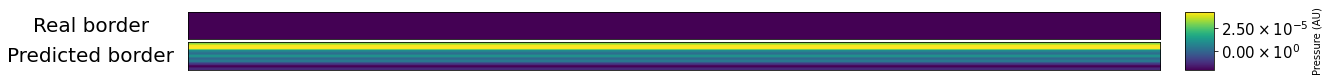

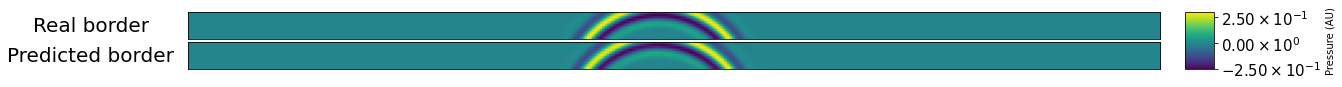

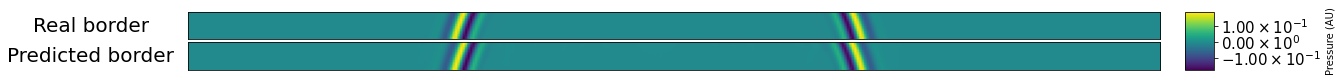

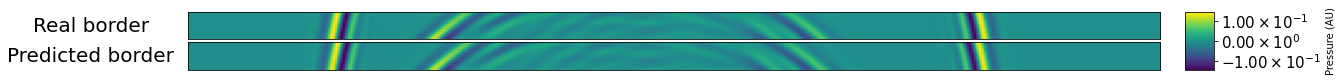

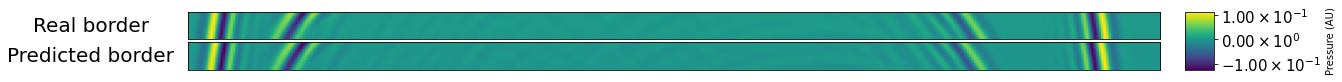

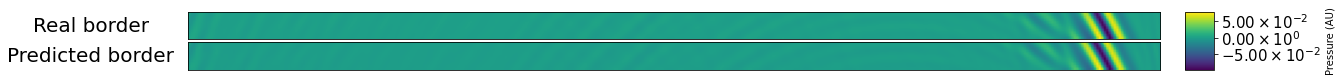

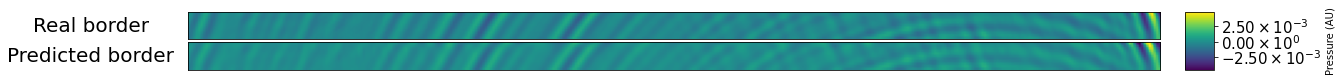

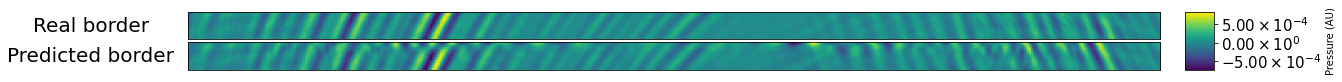

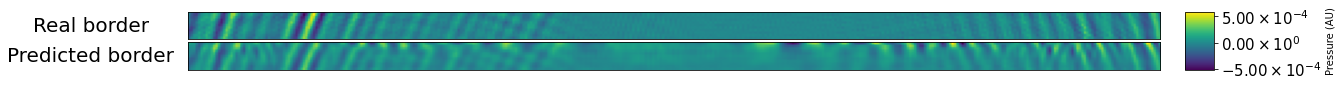

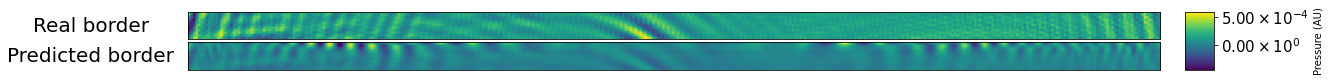

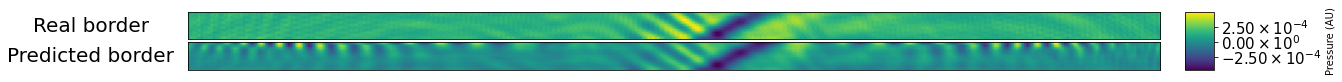

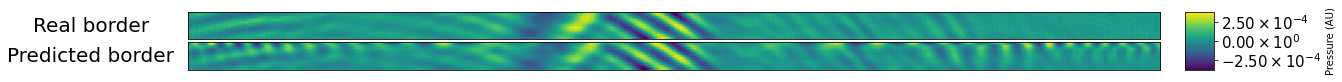

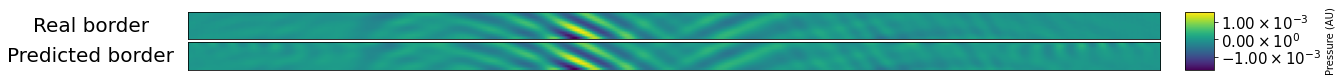

In [ ]:
border_labels = border_labels.squeeze()

for i in range(0,len(border_labels),540*2):

  fig, ax = plt.subplots(2, 1, figsize=(20,1))

  y = ax[0].set_ylabel("Real border", fontsize=20, rotation=0, va="center")
  ax[0].yaxis.set_label_coords(-0.1,0.5)
  b = border_labels[i+75:i+540-75, ]
  b = np.rot90(b,3)
  ax[0].imshow(b)
  ax[0].set_yticks([])
  ax[0].set_xticks([])

  y = ax[1].set_ylabel("Predicted border", fontsize=20, rotation=0, va="center")
  ax[1].yaxis.set_label_coords(-0.1,0.5)
  a = border_predictions[i+75:i+540-75, ]
  a = np.rot90(a,3)
  img = ax[1].imshow(a)
  ax[1].set_yticks([])
  ax[1].set_xticks([])

  fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.85,
                    wspace=0, hspace=0.1)

  cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
  cbar = fig.colorbar(img, cax=cb_ax, format=ticker.FuncFormatter(fmt))
  cbar.ax.set_ylabel('Pressure (AU)', fontsize=10)
  cbar.ax.tick_params(labelsize=15)

  plt.show()